

## Predictive modeling of customer bookings


### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [39]:
import numpy as np 

import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

from imblearn.over_sampling import RandomOverSampler
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline


In [3]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
print(df.shape)
df.head()

(50000, 14)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 


To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [11]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [12]:
df["sales_channel"].value_counts()

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

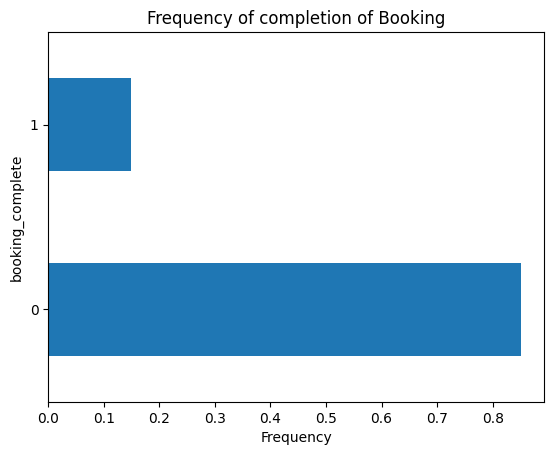

In [16]:
df.booking_complete.value_counts(normalize=True).plot(kind="barh")
plt.xlabel("Frequency")
plt.title("Frequency of completion of Booking")
plt.show()

In [17]:
df.flight_duration.unique()

array([5.52, 5.07, 7.57, 6.62, 7.  , 4.75, 8.83, 7.42, 6.42, 5.33, 4.67,
       5.62, 8.58, 8.67, 4.72, 8.15, 6.33, 5.  , 4.83, 9.5 , 5.13])

In [20]:
df.select_dtypes('object').nunique()

sales_channel       2
trip_type           3
route             799
booking_origin    104
dtype: int64

<Axes: >

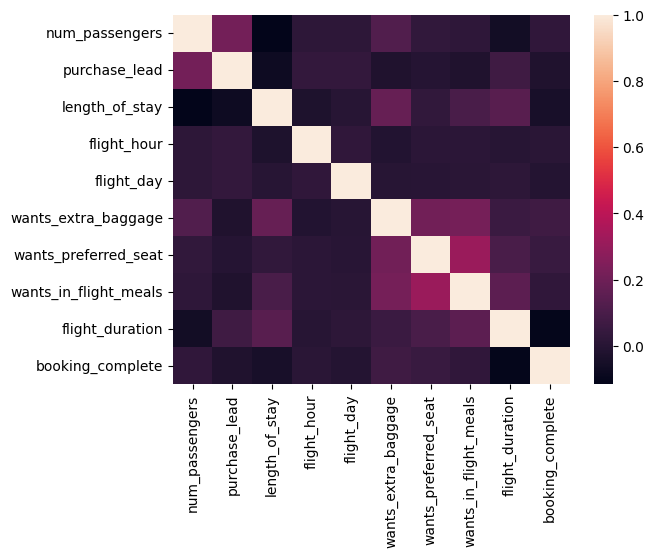

In [22]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr)

In [26]:
numeric_features = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
numeric_features

['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

In [27]:
sc = StandardScaler()
df[numeric_features] = sc.fit_transform(df[numeric_features])

df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,1.957530,-0.119353,-0.381764,6,AKLDEL,New Zealand,1,0,0,-1.174175,0
1,1,Internet,RoundTrip,0.299164,-0.089844,-1.120780,6,AKLDEL,New Zealand,0,0,0,-1.174175,0
2,2,Internet,RoundTrip,1.747470,-0.030824,1.465775,3,AKLDEL,India,1,1,0,-1.174175,0
3,1,Internet,RoundTrip,0.122272,0.234761,-0.936026,6,AKLDEL,New Zealand,0,0,1,-1.174175,0
4,2,Internet,RoundTrip,-0.187290,-0.030824,1.096267,3,AKLDEL,India,1,0,1,-1.174175,0


In [30]:
X = df.drop(columns=['num_passengers', 'route', 'booking_complete'])
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 11)
(10000, 11)
(40000,)
(10000,)


In [38]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (68004, 11)


,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,Mobile,RoundTrip,-0.773246,-0.532487,0.726759,7,Malaysia,0,0,1,-0.439297
1,Internet,RoundTrip,2.355538,-0.561996,-0.012257,1,Thailand,1,0,0,1.037139
2,Internet,RoundTrip,1.272072,-0.502977,-0.751272,3,South Korea,1,0,0,-0.439297
3,Internet,RoundTrip,-0.065677,-0.060334,0.357251,6,Australia,1,0,0,0.870121
4,Internet,RoundTrip,0.221774,-0.089844,-0.566518,7,South Korea,1,0,1,-0.439297


In [33]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.85


In [54]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sales_channel', 'trip_type',
                                     'booking_origin'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [57]:
acc_train =  accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 3))
print("Test Accuracy:", round(acc_test, 3))

Training Accuracy: 0.85
Test Accuracy: 0.852


In [58]:
y_train_pred_proba = model_lr.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.7815682  0.2184318 ]
 [0.79746078 0.20253922]
 [0.90720151 0.09279849]
 [0.954835   0.045165  ]
 [0.88448501 0.11551499]]


In [61]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
importances

c:\Users\igame\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


array([-9.14880854e-01, -2.61938515e-01,  1.67990442e-01, -8.42156022e-01,
       -5.02653789e-01, -8.71353773e-02, -1.39457492e-01,  3.80081979e-02,
       -6.67972023e-03,  1.07169338e+00,  6.09054212e-01, -4.68042860e-01,
       -1.20722783e+00,  8.79571567e-01, -1.63226816e-01,  6.98205236e-01,
       -4.85667597e-01,  4.25503353e-01, -1.02192497e+00,  7.60949588e-01,
       -5.52974604e-01, -4.25864845e-01,  8.75902957e-01,  9.48721710e-01,
        9.27655370e-01, -2.50434595e-01, -1.73944652e+00,  2.95773956e-01,
        4.79799539e-01,  1.07182640e+00, -4.48074467e-01,  6.62770149e-01,
       -1.30838827e+00, -1.69745284e-01, -2.94330317e-01,  6.19415511e-01,
       -9.52240542e-01, -3.30372153e-01, -4.67523055e-01, -7.10417425e-01,
       -5.46316192e-01, -1.39124080e-01,  1.39499334e-01,  1.05337562e+00,
        1.90206264e-01, -3.74130670e-01,  4.87276093e-01, -6.86954347e-02,
        1.38355057e-01,  3.84294945e-01, -7.64806296e-01, -5.00012620e-01,
        5.86073449e-01, -

In [62]:
feat_imp = pd.Series(np.exp(importances), index = features).sort_values()
feat_imp.head()

booking_origin_Sri Lanka               0.175618
booking_origin_Canada                  0.270255
booking_origin_Australia               0.299025
booking_origin_New Zealand             0.359901
booking_origin_United Arab Emirates    0.378529
dtype: float64

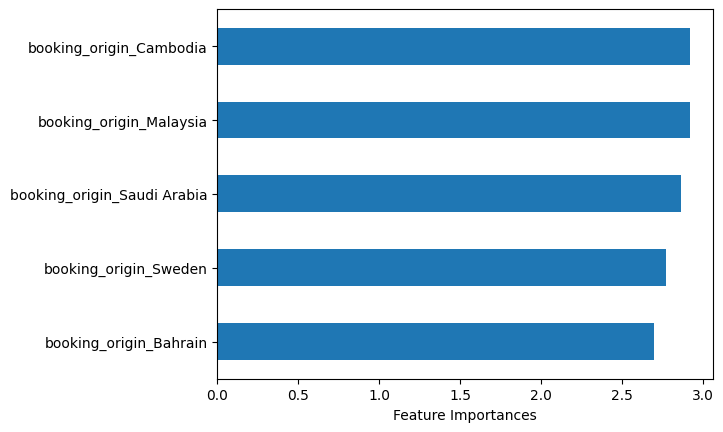

In [63]:
feat_imp.tail().plot(kind = "barh")
plt.xlabel("Feature Importances");

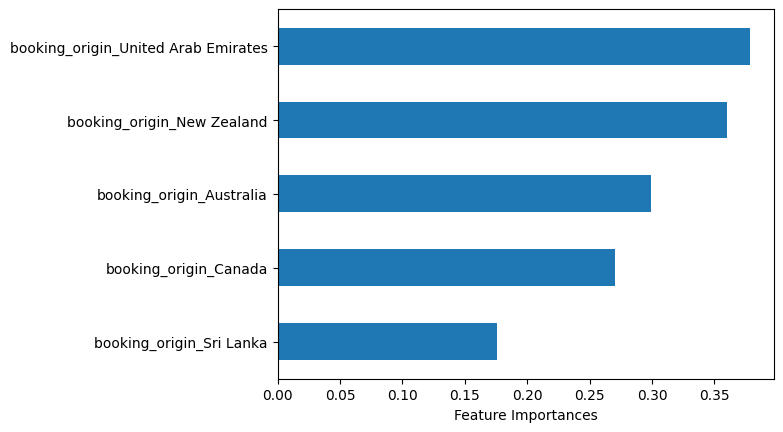

In [64]:
# Horizontal bar chart, five smallest coefficients
feat_imp.head().plot(kind = "barh")
plt.xlabel("Feature Importances");